In [49]:

# Concatonate BERT entities into NER phrases
for file_path, file_path_df in domain_doc_ners_df.groupby('file_path'):
    print()
    print(file_path)
    for entity, entity_df in file_path_df.groupby('bert_entity'):
        print()
        print(entity)
        bert_indices_list = entity_df.bert_index.tolist()
        for indices_list in nu.split_row_indices_list(bert_indices_list):
            mask_series = entity_df.bert_index.isin(indices_list)
            df = entity_df[mask_series]
            ner_phrase = ' '.join(df.bert_word.tolist())
            entity_list = df.bert_entity.tolist()
            
            # Remove subword tokenization
            ner_phrase = ner_phrase.replace(' ##', '')
            if ner_phrase.startswith('##'):
                bert_index = df.bert_index.min() - 1
                mask_series = (file_path_df.bert_index == bert_index)
                df = file_path_df[mask_series]
                if df.shape[0] == 1:
                    bert_word = df.bert_word.squeeze()
                    ner_phrase = bert_word + ner_phrase[2:]
                    entity_list.insert(0, df.bert_entity.squeeze())
            
            print(ner_phrase, entity_list)
    break


../data/Domain_Knowledge/DoDTR-Data-Dictionary-External.pdf

I-LOC


AttributeError: 'DataFrame' object has no attribute 'bert_index'

In [ ]:

from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from statistics import mode

# Named entity recognition pipeline, passing in a specific model and tokenizer
model = AutoModelForTokenClassification.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
token_classifier = pipeline('ner', model=model, tokenizer=tokenizer)

# Example usage showing subword tokenization
sentence = '1 \nDOD TRAUMA REGISTRY \nDATA DICTIONARY \nVersion 3.2, Build 44 - Apr 2018, updated Nov 2019'
tokens = token_classifier(sentence)

# Join subword tokens back together and keep track of entity
output_words = []
current_word = ''
current_entities = []

for metadata_dict in tokens:
    if metadata_dict['word'].startswith('##'):
        current_word += metadata_dict['word'][2:]
        current_entities.append(metadata_dict['entity'])
    else:
        if current_word:
            # Take the mode of entities for the current_word
            mode_entity = mode(current_entities)
            output_words.append((current_word, mode_entity))
            current_word = ""
            current_entities = []
        output_words.append((metadata_dict['word'], metadata_dict['entity']))

# Take the mode of entities for the last current_word
if current_word:
    mode_entity = mode(current_entities)
    output_words.append((current_word, mode_entity))

# Print the result
for word, entity in output_words:
    print(f"{word}: {entity}")

In [7]:

from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

# Converts pdf, returns its text content as a string
def convert(file_path, verbose=False):
    manager = PDFResourceManager()
    with StringIO() as output:
        converter = TextConverter(manager, output, laparams=LAParams())
        interpreter = PDFPageInterpreter(manager, converter)
        with open(file_path, 'rb') as infile:
            for page in PDFPage.get_pages(infile): interpreter.process_page(page)
        converter.close()
        text = output.getvalue()
    if verbose: print(f'Text length for {file_path} is {len(text):,} characters.')
    
    return text

In [8]:

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed

def convert(file_path, verbose=False):
    
    # Create the document model from the file
    parser = PDFParser(open(file_path, 'rb'))
    document = PDFDocument(parser)
    
    # Try to parse the document
    if not document.is_extractable: raise PDFTextExtractionNotAllowed
    
    # Create a PDF resource manager object that stores shared resources
    rsrcmgr = PDFResourceManager()
    
    # Create a buffer for the parsed text
    retstr = StringIO()
    
    # Spacing parameters for parsing
    laparams = LAParams()
    
    # Create a PDF device object
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    
    # Create a PDF interpreter object
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    # Process each page contained in the document.
    for page in PDFPage.create_pages(document): interpreter.process_page(page)
    
    text = retstr.getvalue()
    if verbose: print(f'Text length for {file_path} is {len(text):,} characters.')
    
    return text

In [9]:

import fitz

def convert(file_path, verbose=False):
    doc = fitz.open(file_path)
    text = ''
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text += page.get_text()
    if verbose: print(f'Text length for {file_path} is {len(text):,} characters.')
    
    return text

In [ ]:

        text = re.sub('[^\x00-\x7F]+', '', text)
        text = re.sub('[\x00\x08\x0B\x0C\x0E-\x1F]+', '', text)
        text = text.replace('##', '')

In [3]:

from pandas.tseries.holiday import get_calendar
from datetime import datetime
from calendar import monthrange
import pandas as pd

# Create a calendar with US federal holidays
# https://www.opm.gov/policy-data-oversight/pay-leave/federal-holidays/#url=2023
# https://www.opm.gov/policy-data-oversight/pay-leave/federal-holidays/#url=2024
cal = get_calendar('USFederalHolidayCalendar')
start_dt = datetime(2023, 12, 1)
end_dt = datetime(2024, 2, monthrange(2024, 2)[1])
holidays = cal.holidays(start=start_dt, end=end_dt)

# Generate a "business days" date range for the specified months
date_range = pd.date_range(start=start_dt, end=end_dt, freq='B')

# Filter out holidays from the date range
workdays = date_range[~date_range.isin(holidays)]

# Display workdays by month
workdays_by_month = workdays.to_period('M').value_counts().sort_index()
for month, count in workdays_by_month.items():
    month_str = month.to_timestamp().strftime('%B %Y')
    print(f'Hours in {month_str}: {count*8}')

Hours in December 2023: 160
Hours in January 2024: 168
Hours in February 2024: 160


In [65]:

from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

# Named entity recognition pipeline, passing in a specific model and tokenizer
model = AutoModelForTokenClassification.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
token_classifier = pipeline('ner', model=model, tokenizer=tokenizer)

# Example usage showing subword tokenization
sentence = '1 \nDOD TRAUMA REGISTRY \nDATA DICTIONARY \nVersion 3.2, Build 44 - Apr 2018, updated Nov 2019'
tokens = token_classifier(sentence)
display(' '.join([metadata_dict['word'] for metadata_dict in tokens]).replace(' ##', ''))

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'DOD TRAUMA'

In [59]:

sentence = '1 \nDOD TRAUMA REGISTRY \nDATA DICTIONARY \nVersion 3.2, Build 44 - Apr 2018, updated Nov 2019'# '\n'.join(text.split('\n')[:4])
display(sentence)
print('-'.join(str(x) for x in bytearray(sentence, encoding=nu.encoding_type, errors='replace')))
doc = nlp(sentence)
display(' '.join([word.text for word in doc]))
display(' '.join([ent.text for ent in doc.ents]))
tokens = token_classifier(sentence)
display(' '.join([metadata_dict['word'] for metadata_dict in tokens]))

'1 \nDOD TRAUMA REGISTRY \nDATA DICTIONARY \nVersion 3.2, Build 44 - Apr 2018, updated Nov 2019'

49-32-10-68-79-68-32-84-82-65-85-77-65-32-82-69-71-73-83-84-82-89-32-10-68-65-84-65-32-68-73-67-84-73-79-78-65-82-89-32-10-86-101-114-115-105-111-110-32-51-46-50-44-32-66-117-105-108-100-32-52-52-32-45-32-65-112-114-32-50-48-49-56-44-32-117-112-100-97-116-101-100-32-78-111-118-32-50-48-49-57


'1 \n DOD TRAUMA REGISTRY \n DATA DICTIONARY \n Version 3.2 , Build 44 - Apr 2018 , updated Nov 2019'

'1 3.2 44 - Apr 2018 Nov 2019'

'D ##OD T ##RA ##UM ##A'

In [68]:

for ent in doc.ents:
    print(ent, type(ent))
    attrs_list_dict = {}
    for k in dir(ent):
        v = eval(f'ent.{k}')
        if (type(v) == method_wrapper_class) or k.startswith('_'): continue
        if isinstance(v, types.BuiltinFunctionType):
            try:
                v = v()
                k += '()'
            except: continue
        if (type(v) in [np.ndarray, bytes]): continue
        if (type(v) in [dict]):
            for k1, v1 in v.items():
                attrs_list = attrs_list_dict.get(str(v1), [])
                attrs_list.append(k + '_' + k1)
                attrs_list_dict[str(v1)] = attrs_list
            # print(k, type(v), v.keys())
        else:
            attrs_list = attrs_list_dict.get(str(v), [])
            attrs_list.append(k)
            attrs_list_dict[str(v)] = attrs_list
            # print(k, type(v), v)
    break

Barack Obama <class 'spacy.tokens.span.Span'>


In [69]:

for k_v_tuple in sorted([(str(k), v) for k, v in attrs_list_dict.items()], key=lambda x: x[0]): print(*k_v_tuple)

 ['ent_id_', 'id_', 'kb_id_']
() ['conjuncts']
0 ['ent_id', 'id', 'kb_id', 'n_lefts', 'n_rights', 'start', 'start_char']
0.0 ['sentiment']
12 ['end_char']
2 ['end']
380 ['label']
7.0056767 ['vector_norm']
<generator object at 0x7feba7f23ae0> ['lefts', 'noun_chunks', 'rights', 'sents', 'subtree']
<spacy.vocab.Vocab object at 0x7febad20f8b0> ['vocab']
Barack Obama ['lemma_', 'orth_', 'text']
Barack Obama  ['as_doc()', 'text_with_ws']
Barack Obama was the 44th President of the United States. ['doc', 'sent']
Obama ['root']
PERSON ['label_']
True ['has_vector']
[Barack Obama] ['ents']


In [64]:

for k_v_tuple in sorted([(str(k), v) for k, v in attrs_list_dict.items()], key=lambda x: x[0]): print(*k_v_tuple)

 ['ent_id_', 'ent_kb_id_']
  ['whitespace_']
('', 'I', 'O', 'B') ['iob_strings()']
() ['conjuncts']
-20.0 ['prob']
0 ['cluster', 'ent_id', 'ent_kb_id', 'i', 'idx', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_space', 'is_stop', 'is_upper', 'like_email', 'like_num', 'like_url', 'n_lefts', 'n_rights', 'sent_start', 'sentiment']
12794475650786432352 ['suffix']
14230521632333904559 ['prefix']
14626626061804382878 ['lang']
15388493565120789335 ['lemma', 'orth']
15794550382381185553 ['tag']
16072095006890171862 ['shape']
18446744073709551615 ['lex_id', 'rank']
3 ['ent_iob']
380 ['ent_type']
6953017769113099268 ['lower', 'norm']
7037928807040764755 ['dep']
9.001391 ['vector_norm']
96 ['pos']
<generator object at 0x7feba7f23900> ['ancestors']
<generator object at 0x7feba7f239a0> ['children']
<generator object at 0x7feba7f23a40> ['lefts']
<generator object at 0x7feba7f23ae0> ['rights']
<generator object at 0x7

In [42]:

for ent in doc.ents:
    print(ent, type(ent))
    for k in dir(ent):
        v = eval(f'ent.{k}')
        if (type(v) == method_wrapper_class) or k.startswith('_'): continue
        if isinstance(v, types.BuiltinFunctionType):
            try:
                v = v()
                k += '()'
            except: continue
        if (type(v) in [np.ndarray, bytes]): continue
        if (type(v) in [dict]): print(k, type(v), v.keys())
        else: print(k, type(v), v)
    break

Barack Obama <class 'spacy.tokens.span.Span'>
as_doc() <class 'spacy.tokens.doc.Doc'> Barack Obama 
conjuncts <class 'tuple'> ()
doc <class 'spacy.tokens.doc.Doc'> Barack Obama was the 44th President of the United States.
end <class 'int'> 2
end_char <class 'int'> 12
ent_id <class 'int'> 0
ent_id_ <class 'str'> 
ents <class 'list'> [Barack Obama]
has_vector <class 'bool'> True
id <class 'int'> 0
id_ <class 'str'> 
kb_id <class 'int'> 0
kb_id_ <class 'str'> 
label <class 'int'> 380
label_ <class 'str'> PERSON
lefts <class 'generator'> <generator object at 0x7feb9e4c6cc0>
lemma_ <class 'str'> Barack Obama
n_lefts <class 'int'> 0
n_rights <class 'int'> 0
noun_chunks <class 'generator'> <generator object at 0x7feb9e4c6cc0>
orth_ <class 'str'> Barack Obama
rights <class 'generator'> <generator object at 0x7feb9e4c6cc0>
root <class 'spacy.tokens.token.Token'> Obama
sent <class 'spacy.tokens.span.Span'> Barack Obama was the 44th President of the United States.
sentiment <class 'float'> 0.0
se

In [46]:

for k in dir(ent.vocab):
    v = eval(f'ent.vocab.{k}')
    if (type(v) == method_wrapper_class) or k.startswith('_'): continue
    if isinstance(v, types.BuiltinFunctionType):
        try:
            v = v()
            k += '()'
        except: continue
    if (type(v) in [np.ndarray, bytes]): continue
    if (type(v) in [dict]): print(k, type(v), v.keys())
    else: print(k, type(v), v)

cfg <class 'dict'> dict_keys(['oov_prob'])
get_noun_chunks <class 'function'> <function noun_chunks at 0x7febad4eaee0>
lang <class 'str'> en
length <class 'int'> 772
lex_attr_getters <class 'dict'> dict_keys([66, 67, 69, 70, 1, 3, 4, 6, 7, 8, 12, 11, 10, 5, 2, 68, 14, 15, 16, 17, 18, 9, 83])
lookups <class 'spacy.lookups.Lookups'> <spacy.lookups.Lookups object at 0x7feba7f47a60>
morphology <class 'spacy.morphology.Morphology'> <spacy.morphology.Morphology object at 0x7febac02f740>
reset_vectors() <class 'NoneType'> None
strings <class 'spacy.strings.StringStore'> <spacy.strings.StringStore object at 0x7feb97438220>
vectors <class 'spacy.vectors.Vectors'> <spacy.vectors.Vectors object at 0x7feba7f232c0>
vectors_length <class 'int'> 0
writing_system <class 'dict'> dict_keys(['direction', 'has_case', 'has_letters'])


In [18]:

for k, v in doc.to_dict().items():
    if (type(v) in [str, float, dict, list, bool]): print(k, v)

text Barack Obama was the 44th President of the United States.
sentiment 0.0
cats {}
strings ['', 'PERSON', 'JJ', 'was', 'GPE', '.', 'Barack', 'of', 'barack', 'united', 'DT', 'prep', 'amod', 'United', 'Definite=Def|PronType=Art', 'PunctType=Peri', 'Number=Sing', 'NNP', 'VBD', '44th', 'Obama', 'obama', 'ROOT', 'compound', 'pobj', 'IN', 'be', 'Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin', 'ORDINAL', 'det', 'nsubj', 'President', 'attr', 'the', 'States', 'states', 'punct', 'president', 'Degree=Pos']
has_unknown_spaces False


In [41]:

import inspect
import types

method_wrapper_class = type(eval(f'doc.__eq__'))
for k in dir(doc):
    v = eval(f'doc.{k}')
    if (type(v) == method_wrapper_class) or k.startswith('_'): continue
    if isinstance(v, types.BuiltinFunctionType):
        try:
            v = v()
            k += '()'
        except: continue
    if (type(v) in [np.ndarray, bytes]): continue
    if (type(v) in [dict]): print(k, type(v), v.keys())
    else: print(k, type(v), v)

cats <class 'dict'> dict_keys([])
copy() <class 'spacy.tokens.doc.Doc'> Barack Obama was the 44th President of the United States.
doc <class 'spacy.tokens.doc.Doc'> Barack Obama was the 44th President of the United States.
ents <class 'tuple'> (Barack Obama, 44th, the United States)
has_unknown_spaces <class 'bool'> False
has_vector <class 'bool'> True
is_nered <class 'bool'> True
is_parsed <class 'bool'> True
is_sentenced <class 'bool'> True
is_tagged <class 'bool'> True
lang <class 'int'> 14626626061804382878
lang_ <class 'str'> en
mem <class 'cymem.cymem.Pool'> <cymem.cymem.Pool object at 0x7feb973cf270>
noun_chunks <class 'generator'> <generator object at 0x7fed1288c9a0>
noun_chunks_iterator <class 'function'> <function noun_chunks at 0x7febad4eaee0>
retokenize() <class 'spacy.tokens._retokenize.Retokenizer'> <spacy.tokens._retokenize.Retokenizer object at 0x7feba5646ea0>
sentiment <class 'float'> 0.0
sents <class 'generator'> <generator object at 0x7fed1288c9a0>
spans <class 'spac

In [49]:

for noun_chunk in doc.noun_chunks:
    print(noun_chunk)

Barack Obama
the 44th President
the United States


In [48]:

doc.noun_chunks_iterator??

Signature:
doc.noun_chunks_iterator(
    doclike: Union[spacy.tokens.doc.Doc, spacy.tokens.span.Span],
) -> Iterator[Tuple[int, int, int]]
Source:   
def noun_chunks(doclike: Union[Doc, Span]) -> Iterator[Tuple[int, int, int]]:
    """
    Detect base noun phrases from a dependency parse. Works on both Doc and Span.
    """
    labels = [
        "oprd",
        "nsubj",
        "dobj",
        "nsubjpass",
        "pcomp",
        "pobj",
        "dative",
        "appos",
        "attr",
        "ROOT",
    ]
    doc = doclike.doc  # Ensure works on both Doc and Span.
    if not doc.has_annotation("DEP"):
        raise ValueError(Errors.E029)
    np_deps = [doc.vocab.strings.add(label) for label in labels]
    conj = doc.vocab.strings.add("conj")
    np_label = doc.vocab.strings.add("NP")
    prev_end = -1
    for i, word in enumerate(doclike):
        if word.pos not in (NOUN, PROPN, PRON):
            continue
        # Prevent nested chunks from being produced
        if word.left

In [60]:

for word in doc:
    print(word, type(word))
    attrs_list_dict = {}
    for k in dir(word):
        v = eval(f'word.{k}')
        if (type(v) == method_wrapper_class) or k.startswith('_'): continue
        if isinstance(v, types.BuiltinFunctionType):
            try:
                v = v()
                k += '()'
            except: continue
        if (type(v) in [np.ndarray, bytes]): continue
        if (type(v) in [dict]):
            for k1, v1 in v.items():
                attrs_list = attrs_list_dict.get(v1, [])
                attrs_list.append(k + '_' + k1)
                attrs_list_dict[v1] = attrs_list
            # print(k, type(v), v.keys())
        else:
            attrs_list = attrs_list_dict.get(v, [])
            attrs_list.append(k)
            attrs_list_dict[v] = attrs_list
            # print(k, type(v), v)
    break

Barack <class 'spacy.tokens.token.Token'>


In [ ]:

from llama_index import ServiceContext
from llama_index.postprocessor import NERPIINodePostprocessor
from llama_index.schema import TextNode
from llama_index.schema import NodeWithScore

# Please set either the OPENAI_API_KEY environment variable or openai.api_key prior to initialization
os.environ['OPENAI_API_KEY'] = wsu.secrets_json['OPENAI_API_KEY']
service_context = ServiceContext.from_defaults()
processor = NERPIINodePostprocessor(service_context=service_context)

In [4]:

from llama_index import postprocessor

dir(postprocessor)

['AutoPrevNextNodePostprocessor', 'CohereRerank', 'EmbeddingRecencyPostprocessor', 'FixedRecencyPostprocessor', 'KeywordNodePostprocessor', 'LLMRerank', 'LongContextReorder', 'LongLLMLinguaPostprocessor', 'MetadataReplacementPostProcessor', 'NERPIINodePostprocessor', 'PIINodePostprocessor', 'PrevNextNodePostprocessor', 'SentenceEmbeddingOptimizer', 'SentenceTransformerRerank', 'SimilarityPostprocessor', 'TimeWeightedPostprocessor', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cohere_rerank', 'llm_rerank', 'longllmlingua', 'metadata_replacement', 'node', 'node_recency', 'optimizer', 'pii', 'sbert_rerank', 'types']

In [ ]:

for line in [lines_list[i] for i in import_indices_list]:
    library_names_list = line.split('"')[1].split('\\n')[0].split('import ')[1].split(' as ')[-1].split(', ')
    display(line, library_names_list)


<h2>Results/Findings and Discussion</h2>
<h3>Sequencing</h3>
<p>An exploratory analysis on trainee decision points that highlights the variance in responses to the same situation requires visualizing if any sequence is even discernable. We found no significant patterns between event time and elapsed time:</p>
<p>This was corroborated by the Research Lead, who stated that the event time should be eliminated as a useful measure. Still, we noticed that consecutive minutes of event time naturally grouped events. This was also corroborated by him, who made us understand that the Session UUID was grouped by <em>SESSION_END</em> and <em>SESSION_START</em> events, though they were sometimes missing and sometimes were preceded by logged events that should have been logged <em>after</em> the <em>SESSION_START</em>.</p>
<h3>Post-engagement Transactions for Affinity Analysis</h3>
<p>We used affinity analysis to find some common events surrounding the <em>PATIENT_ENGAGED</em> event. This gave a us a general idea of event sequences, but nothing that would allow us to infer a <em>PATIENT_ENGAGEMENT_END</em> event, for instance. Below are the paired post-engagement actions with their various metrics.</p>


<p>Here are the actions with the highest antecedent support:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.053873</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.011694</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.045525</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.845047</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>-0.002144</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.991254</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>-0.197913</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.980934</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.844200</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>39.065447</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.995612</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE, S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.010195</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.010195</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.039689</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.892996</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.007576</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.030713</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest consequent support:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.053873</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.011694</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.217069</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.845047</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>-0.002144</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.949162</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>-0.162343</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.987466</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.844200</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>59.287716</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.993341</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE, S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.010195</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.010195</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.892996</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.007576</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.750783</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest support:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.987466</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.8442</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>59.287716</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.993341</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.980934</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.8442</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>39.065447</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.995612</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest confidence:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(BAG_CLOSED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(TELEPORT)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.130035</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>7.690238</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.112517</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.999196</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.033867</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.997721</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.015587</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.978462</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALKED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALK_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.215292</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>4.644847</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.164471</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.992792</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.053873</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>18.562152</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.044162</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.992451</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest lift:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.941176</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.033867</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>16.401899</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.033867</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.997721</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.433155</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.015587</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.735586</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.015587</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.978462</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD, SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.013993</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.013993</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.000000</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.013470</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.976280</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest leverage:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.987466</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.8442</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>59.287716</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.993341</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_COMMAND)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(VOICE_CAPTURE)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.256872</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.255172</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.251974</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.980934</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3.8442</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.186427</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>39.065447</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.995612</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest conviction:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(BAG_CLOSED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(TELEPORT)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.130035</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>7.690238</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.112517</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.999196</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.033867</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.997721</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.015587</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.978462</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALKED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALK_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.215292</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>4.644847</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.164471</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.992792</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.053873</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>18.562152</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.044162</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>inf</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.992451</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Here are the actions with the highest Zhang’s metric:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
                <col style="width: 74.9px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequents</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>antecedent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>consequent support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>support</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>confidence</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>lift</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>leverage</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>conviction</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>Zhangs metric</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(TELEPORT)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(BAG_CLOSED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.130035</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.129335</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.994620</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>7.690238</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.112517</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>161.819248</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(INJURY_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.035182</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.941176</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.033867</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>16.401899</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(PATIENT_RECORD)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(SESSION_START)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.037381</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.016192</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.433155</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>26.751337</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.015587</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.735586</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALK_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WALKED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.215292</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.209595</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.973538</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>4.644847</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.164471</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>29.868981</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVE_IF_CAN)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(S_A_L_T_WAVED)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.053873</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.046677</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.866419</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>18.562152</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0.044162</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>7.136684</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1.0</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<h3>Action Types</h3>
<p>It’s important to note that the logger tracks actions. Whether the automatic actions of the patients, the instantaneous actions of the trainee (<em>PATIENT_RECORD</em>, <em>INJURY_RECORD</em>), or their deliberate actions, every action is given an time stamp and an action type. The distribution of action types (the most common values, the least common values, and the relative frequencies of different values) can be seen here:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 378.5px;">
                <col style="width: 378.5px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>action_type</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>count</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>BAG_ACCESS</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2180</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>BAG_CLOSED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2149</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>INJURY_RECORD</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3052</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>INJURY_TREATED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1577</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>PATIENT_DEMOTED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1818</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>PATIENT_ENGAGED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2295</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>PATIENT_RECORD</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2063</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>PULSE_TAKEN</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>3427</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>SESSION_END</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>256</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>SESSION_START</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>266</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>S_A_L_T_WALKED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2725</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>S_A_L_T_WALK_IF_CAN</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>4567</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>S_A_L_T_WAVED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1761</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>S_A_L_T_WAVE_IF_CAN</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2147</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TAG_APPLIED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1819</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TAG_DISCARDED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>533</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TAG_SELECTED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2353</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TELEPORT</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>5678</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TOOL_APPLIED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1818</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TOOL_DISCARDED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>1655</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TOOL_HOVER</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>89733</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>TOOL_SELECTED</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2263</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>VOICE_CAPTURE</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>10115</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>VOICE_COMMAND</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2916</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>(Note that the number of <em>SESSION_START</em>s does not equal the number of <em>SESSION_END</em>s in the dataset. This is an artifact of the logging process.) DM actions can also be grouped according to <strong>patient_id</strong>s (which show up in the <strong>patient_demoted_id</strong>, <strong>patient_record_id</strong>, <strong>injury_record_patient_id</strong>, <strong>s_a_l_t_walk_if_can_patient_id</strong>, <strong>s_a_l_t_walked_patient_id</strong>, <strong>s_a_l_t_wave_if_can_patient_id</strong>, <strong>s_a_l_t_waved_patient_id</strong>, <strong>patient_engaged_id</strong>, <strong>pulse_taken_patient_id</strong>, <strong>injury_treated_patient_id</strong>, <strong>tool_applied_patient_id</strong>, and <strong>tag_applied_patient_id</strong> columns):</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
                <col style="width: 93.875px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>action_type</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>action_ticks</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>event_time</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>tag_applied_type</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>patient_id</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>location_id</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>scene_index</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>51240</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>PATIENT_ENGAGED</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>299882</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2023-06-07 10:30:00</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>Bob_0 Root</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>(-1.7, 0.0, 5.7)</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>51241</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>PULSE_TAKEN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>302752</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2023-06-07 10:30:00</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>Bob_0 Root</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>51243</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>PULSE_TAKEN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>304272</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2023-06-07 10:30:00</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>Bob_0 Root</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>51247</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>TAG_APPLIED</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>313242</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>2023-06-07 10:31:00</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>black</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>Bob_0 Root</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>NaN</p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>0</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>This allows us to discern what all is being done for each patient. When placed on a timeline, we can see how the patients are all initialized at session start and can visualize how the DM moves from patient to patient:</p>


<h3>Voice Commands</h3>
<p>The distribution of the various voice commands can be seen here:</p>
<div style="width: 760px;">
    <div>
        <table>
            <colgroup>
                <col style="width: 378.5px;">
                <col style="width: 378.5px;">
            </colgroup>
            <tbody>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>voice_command_message</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p><strong>count</strong></p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>anywhere else</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>80</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>are you hurt</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>730</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>can you hear</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>49</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>hold still</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>7</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>lay down</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>66</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>modbutton groan</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>41</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>modbutton im okay</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>136</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>modbutton no</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>177</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>modbutton yes</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>84</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>reveal injury</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>130</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>sit up/down</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>65</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>stand up</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>118</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>walk to the safe area</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>605</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>wave if you can</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>566</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>what is your name</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>38</p>
                    </td>
                </tr>
                <tr>
                    <td rowspan="1" colspan="1">
                        <p><strong>where are you</strong></p>
                    </td>
                    <td rowspan="1" colspan="1">
                        <p>24</p>
                    </td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<p>Each voice command sets off its own series of events. Here is an examination of the first few log entries after each command:</p>
<h4>"Wave if you can" Events</h4>
<p>"Wave if you can" events seemed most promising to our goals as that was as close to the decision point as we could get in the logs. The DM would immediately teleport to a non-waving patient after this event:</p>
<h3>Location Points and Teleportation Events</h3>
<p>It was discovered that there is a list of columns (<strong>teleport_location</strong>, <strong>patient_demoted_position</strong>, <strong>patient_record_position</strong>, <strong>injury_record_injury_injury_locator</strong>, <strong>s_a_l_t_walk_if_can_sort_location</strong>, <strong>s_a_l_t_walked_sort_location</strong>, <strong>s_a_l_t_wave_if_can_sort_location</strong>, <strong>s_a_l_t_waved_sort_location</strong>, <strong>patient_engaged_position</strong>, <strong>bag_access_location</strong>,<strong>injury_treated_injury_injury_locator</strong>, <strong>bag_closed_location</strong>, <strong>tag_discarded_location</strong>, and <strong>tool_discarded_location</strong>) that have 3D coordinates as values in them. After consultation with the Research Lead, we also verified that the y coordinates are always zero. Visualizing this on a 2D plane reveals that patient and teleport location coordinates are all absolute references (confirmed by him):</p>
<p>Unfortunately, if the DM doesn't teleport, we don't know where they went to. So, a DM can walk around a while, then figure out how to teleport. We have no location information until they teleport, and the first coordinate available is where they first teleported to.</p>
<p>Th Research Head proffered a theory that <em>TOOL_HOVER</em>ing could indicate the next patient choice. It turns out that the last previous tool hover correctly anticipates the required injury procedure for each patient engaged only 65.5% of the time.</p>
<h3>Elapsed Time Spent on Patient and Tool</h3>
<p>Here we visualize a histogram of the time delta between the first time a patient ID appears in the logs and the last time a patient ID appears in the logs, for each session:</p>
<p>The maximum deltas are an artifact of the logging process at the end of a session. This artifact also shows up in the maximum length of time a tool is used:</p>
<p>The “walk to a safe area” and “wave if you can” voice commands are dependent on the simulation responding and are instantaneous for the first patient. It's probably the second person to respond to the command that gets less than 100 milliseconds delta:</p>
<p>Here is a summary of the response times. NaT is just "not a time" - meaning it couldn't find a node for that series:</p>


<h2>Recommendations</h2>
<p>The Research Lead sent an updated package that fixes these issues to the developer for integration. His update:</p>
<ul>
    <li>
        <p>Optimizes the capture frequency of PlayerLocation and PlayerGaze records and exposes the frequency of capture as a parameter in editor. The TeleportWatcher is attached to the Player prefab and may be configured there. The default capture frequency is 2x per second.</p>
    </li>
    <li>
        <p>Improves PlayerGaze by generating larger targets to identify when gaze falls on patients in the distance, even when the patient is in low LOD range.</p>
    </li>
    <li>
        <p>Fixes issue found by …: Decomp Needle now reports the correct patient ID in the corresponding ToolApplied record.</p>
    </li>
</ul>
<p>It is recommended that his updates be added to the logger.</p>


<h2>Appendices</h2>
<h3>Appendix A: MCIVR Metrics Types (Document located <a href="/wiki/spaces/ITM/pages/2999156737" title="/wiki/spaces/ITM/pages/2999156737">here</a> and <a href="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/data/docx/MCIVR_MetricsTypes%5B10%5D.docx" title="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/data/docx/MCIVR_MetricsTypes%5B10%5D.docx">here</a>)</h3>
<h3>Appendix B: Dataset Build Algorithm (Algorithm located <a href="https://github.com/NextCenturyCorporation/itm-analysis-reporting/blob/main/builders/Build%20the%20OSU%20dataset%20of%20Simulation%20Sessions.ipynb" title="https://github.com/NextCenturyCorporation/itm-analysis-reporting/blob/main/builders/Build%20the%20OSU%20dataset%20of%20Simulation%20Sessions.ipynb">here</a>)</h3>
<h3>Appendix C: Patient Engagement Timeline (Document located <a href="/wiki/spaces/ITM/pages/2999156737" title="/wiki/spaces/ITM/pages/2999156737">here</a> and <a href="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/saves/csv/patient_engagement_timeline_df.csv" title="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/saves/csv/patient_engagement_timeline_df.csv">here</a>)</h3>
<h3>Appendix D: Dataset of Doug Danforth’s FRVRS logs as CSV (Document located <a href="/wiki/spaces/ITM/pages/2999156737" title="/wiki/spaces/ITM/pages/2999156737">here</a> and <a href="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/saves/csv/clean_csvs_df.csv" title="https://github.com/NextCenturyCorporation/itm-analysis-reporting/raw/main/saves/csv/clean_csvs_df.csv">here</a>)</h3


<h2>Introduction</h2>
<p>The FRVRS is a high-fidelity, fully immersive, automated, programmable virtual reality (VR) simulation designed to train frontline responders to treat and triage victims of mass casualty incidents. The VR platform tracks and records (logs) their performance as they navigate the disaster scene. Output from the system provides feedback to participants on their performance, and, in our case, a statistically analyzable dataset of patient engagement events. The Subject Matter Experts (SMEs) have kept version 1.0 of these logs of participant trainees for our analysis.</p>
<p>The purpose of this FRVRS Logs Dataset Analysis Report (FLDAR) is to provide TA1 with a dataset of the SME’s FRVRS logs in addition to anything useful to be found in analyzing the decisions taken by the first responder trainees (DMs) of the FRVRS.</p>


<h2>Executive Summary</h2>
<p>Version 1.0 of the First Responder Virtual Reality Simulator (FRVRS) logger does not provide a moment-by-moment record of the whereabouts of the first responder trainee (DM), nor an indication of which patient is being observed. Therefore, we are unable to accurately model a theory of mind with respect to the DM's decisions. It is recommended in later versions that <em>DM_GAZE</em>, <em>PATIENT_ENGAGEMENT_END</em> and <em>DM_LOCATION</em> be added to the action types that the logger tracks.</p>

In [7]:

# Calculate the frequency of use for each feature name
feature_frequency = tfidf_matrix.sum(axis=0)

# Create a data frame to display the feature frequencies
feature_frequency_df = DataFrame(data=feature_frequency, columns=feature_names)

# Sort the data frame by feature frequencies in descending order
feature_frequency_df = feature_frequency_df.sort_values(by=0, axis=1, ascending=False)

# Display the feature frequency data frame
df = feature_frequency_df.T.rename(columns={0: 'frequency'})
mask_series = (df.frequency > 5)
overused_list = df[mask_series].index.tolist()
display(df[~mask_series].head(20))

,frequency
random,3.528643
apriori,2.854371
colors,2.127919
association_rules,2.054312
seaborn,1.685165
en_core_web_sm,1.115181
spacy,1.115181
generate_item_bank,0.936932
icc,0.936932
catsim,0.936932


In [6]:

file_name = 'Time Spent on Task.ipynb'
not any(map(lambda x: x in file_name, ['Analy', 'Explor']))

True


## Remove training sessions

In [14]:

import docx

logs_folder = nu.data_logs_folder
for sub_directory, directories_list, files_list in os.walk(logs_folder):
    for file_name in files_list:
        if file_name.endswith('.docx'):
            file_path = os.path.join(sub_directory, file_name)
            print(file_path)
            doc = docx.Document(file_path)
            text = ''
            for paragraph in doc.paragraphs: text += '\n' + paragraph.text
            print(text)

C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\data\logs\All CSV files renamed by date\Notes.docx

DCEMS 11.22 – 12.22 – OK
Madison Township 4.18.23 and 4.20.23 – Training and Triage are combined.
Union County Marysville 04.25.23 - Training and Triage are combined.
Disaster Day 3.14.23 and 3.15.23 are almost all combined.




Please use First <i>VR</i>esponder for the name of the simulation (VR in italics).

In [3]:

# Example usage
zero_seconds_s = fu.format_timedelta(timedelta(seconds=0), minimum_unit='seconds')
zero_seconds_m = fu.format_timedelta(timedelta(seconds=0), minimum_unit='minutes')
thirty_seconds_s = fu.format_timedelta(timedelta(seconds=30), minimum_unit='seconds')
thirty_seconds_m = fu.format_timedelta(timedelta(seconds=30), minimum_unit='minutes')
one_minute_s = fu.format_timedelta(timedelta(minutes=1, seconds=0), minimum_unit='seconds')
one_minute_m = fu.format_timedelta(timedelta(minutes=1, seconds=0), minimum_unit='minutes')
a_minute_and_a_half_s = fu.format_timedelta(timedelta(minutes=1, seconds=30), minimum_unit='seconds')
a_minute_and_a_half_m = fu.format_timedelta(timedelta(minutes=1, seconds=30), minimum_unit='minutes')
two_minute_s = fu.format_timedelta(timedelta(minutes=2, seconds=0), minimum_unit='seconds')
two_minute_m = fu.format_timedelta(timedelta(minutes=2, seconds=0), minimum_unit='minutes')

print(
    f"zero seconds: '{zero_seconds_s}' or '{zero_seconds_m}'\n"
    f"thirty seconds: '{thirty_seconds_s}' or '{thirty_seconds_m}'\n"
    f"one minute: '{one_minute_s}' or '{one_minute_m}'\n"
    f"a minute and a half: '{a_minute_and_a_half_s}' or '{a_minute_and_a_half_m}'\n"
    f"two minutes: '{two_minute_s}' or '{two_minute_m}'"
)

zero seconds: '0 sec' or '00:00'
thirty seconds: '30 sec' or '00:30'
one minute: '1 min' or '01:00'
a minute and a half: '1:30' or '01:30'
two minutes: '2 min' or '02:00'


In [29]:

soup = nu.get_page_soup(page_url_or_filepath=r'C:\Users\DaveBabbitt\Downloads\Book2.html', verbose=False)
union_set = set()
for tag in soup.find_all(attrs={'style': True}):
    if(tag.name == 'td'): union_set = union_set.union(set([style for style in tag['style'].split(';') if style]))
intersection_set = union_set.copy()
for tag in soup.find_all(attrs={'style': True}):
    if(tag.name == 'td'): intersection_set = intersection_set.intersection(set([style for style in tag['style'].split(';') if style]))
print(' style="' + ';'.join(intersection_set) + ';"')

 style=";"


In [ ]:

soup = nu.get_page_soup(page_url_or_filepath=r'C:\Users\DaveBabbitt\Downloads\Book2.html', verbose=False)
for tr_soup in soup.find_all('tr'):
    union_set = set()
    for tag in tr_soup.children:
        if(tag.name == 'td'): union_set = union_set.union(set([style for style in tag['style'].split(';') if style]))
    intersection_set = union_set.copy()
    for tag in tr_soup.children:
        if(tag.name == 'td'): intersection_set = intersection_set.intersection(set([style for style in tag['style'].split(';') if ('style' in tag) and style]))
    print(' style="' + ';'.join(intersection_set) + ';"')

In [24]:


for _, scene_df in frvrs_logs_df[base_mask_series].groupby(fu.scene_groupby_columns):
    mask_series = scene_df.injury_record_required_procedure.isin(fu.hemorrhage_control_procedures_list)
    hemorrhage_df = scene_df[mask_series]
    mask_series = scene_df.injury_treated_required_procedure.isin(fu.hemorrhage_control_procedures_list)
    controlled_df = scene_df[mask_series]
    on_columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file', 'patient_id', 'injury_id']
    merged_columns_list = ['patient_id', 'injury_id', 'action_type_hemorrhage', 'elapsed_time_hemorrhage', 'action_type_controlled', 'elapsed_time_controlled']
    df = hemorrhage_df.merge(controlled_df, on=on_columns_list, suffixes=('_hemorrhage', '_controlled'))
    display(df[merged_columns_list].dropna(axis='columns', how='all').T)
    break

,0,1,2,3,4,5,6,7
patient_id,Lily_2 Root,Mike_7 Root,Mike_5 Root,Mike_5 Root,Mike_5 Root,Mike_5 Root,Lily_4 Root,Lily_4 Root
injury_id,R Shin Amputation,L Thigh Puncture,R Side Puncture,R Side Puncture,R Side Puncture,R Side Puncture,L Side Puncture,L Side Puncture
action_type_hemorrhage,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD
elapsed_time_hemorrhage,305827,305828,305828,305828,305828,305828,305828,305828
action_type_controlled,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED,INJURY_TREATED
elapsed_time_controlled,413178,557878,455202,457962,459965,465953,616862,619563


In [29]:

mask_series = False
for cn in fu.sort_columns_list: mask_series |= (scene_df[cn] == 'still')
[cn for cn in frvrs_logs_df.columns if cn.endswith('_sort')]

['patient_demoted_sort', 'patient_record_sort', 'patient_engaged_sort']

In [18]:

columns_list = ['scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,scene_type,is_scene_aborted,is_a_one_triage_file
131522,Orientation,False,False
0,Orientation,False,True
71303,Triage,False,False
228,Triage,False,True


In [20]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
mask_series = base_mask_series & frvrs_logs_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
total_bleeder_scenes_count = len(frvrs_logs_df[mask_series].groupby(fu.scene_groupby_columns).groups)
total_bleeders_count = len(frvrs_logs_df[mask_series].groupby(fu.scene_groupby_columns+['patient_id']).groups)
print(f'{total_bleeders_count:,} total bleeders in {total_bleeder_scenes_count} total scenes.')

1,471 total bleeders in 371 total scenes.


In [16]:

bleeder_scene_count = len(gb.groups)
total_scene_count = len(frvrs_logs_df[base_mask_series].groupby(fu.scene_groupby_columns).groups)
print(
    f"Of the one-per-file triage scenes that have tourniquet or woundpack as injury treated required procedures in them ({bleeder_scene_count}"
    f" scenes out of a total of {total_scene_count}), here is the bleeding/treated patient count:"
)

Of the one-per-file triage scenes that have tourniquet or woundpack as injury treated required procedures in them (371 scenes out of a total of 389), here is the bleeding/treated patient count:


In [17]:

groupby_columns = ['is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated']
df = run_control_time_df.groupby(groupby_columns).size().reset_index(drop=False).rename(columns={0: 'patient_count'})
display(df.sort_values([
    'patient_count', 'is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated'
], ascending=[False, True, True, True]))

,is_patient_bleeding,is_correct_tool_applied,is_bleeding_treated,patient_count
2,True,True,True,287
1,True,True,False,57
0,False,False,False,27


In [60]:

run_control_time_df.columns.tolist()

['session_uuid', 'scene_index', 'scene_start', 'patient_id', 'is_patient_bleeding', 'is_correct_tool_applied', 'is_bleeding_treated', 'patient_engagement_time', 'tool_applied_time', 'run_tool_control_time', 'engaged_tool_control_time']

In [9]:

columns_list = ['run_control_time']
df = run_control_time_df.groupby(groupby_columns)[columns_list].max()
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
run_control_time,3:56,25 sec,3:51,±1:44,25 sec,2:41,3:51,4:52,10:49


In [ ]:

# Get the total and bleeder scene count
base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
mask_series = base_mask_series & frvrs_logs_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])

# Iterate through each patient in each run in each file
rows_list = []
for (session_uuid, scene_index), injury_treated_df in frvrs_logs_df[mask_series].groupby(fu.scene_groupby_columns):
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    
    # Get the entire history of this scene for the run start
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    scene_df = frvrs_logs_df[mask_series]
    time_start = fu.get_scene_start(scene_df)
    row_dict['scene_start'] = time_start
    
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['is_patient_bleeding'] = fu.is_injury_hemorrhage(patient_df)
        row_dict['is_bleeding_treated'] = fu.is_injury_correctly_treated(patient_df)
        
        # Is this patient bleeding?
        bleeding_mask_series = patient_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
        if patient_df[bleeding_mask_series].shape[0]:
            
            # Get the time of patient engagement
            patient_engaged = fu.get_first_engagement(patient_df)
            row_dict['patient_engagement_time'] = patient_engaged
            
            # Get the entire history of the patients that had these injuries
            injury_mask_series = True
            for cn in fu.scene_groupby_columns: injury_mask_series &= (frvrs_logs_df[cn] == eval(cn))
            injury_mask_series &= (
                (frvrs_logs_df.injury_record_patient_id == patient_id) |
                (frvrs_logs_df.injury_treated_patient_id == patient_id) |
                (frvrs_logs_df.tool_applied_patient_id == patient_id)
            )
            
            # Add the entire history of these injuries
            injury_ids_list = patient_df[bleeding_mask_series].injury_treated_id.tolist()
            injury_mask_series &= (
                frvrs_logs_df.injury_record_id.isin(injury_ids_list) |
                frvrs_logs_df.injury_treated_id.isin(injury_ids_list) |
                frvrs_logs_df.injury_id.isnull()
            )
            # injury_mask_series &= frvrs_logs_df.action_type.isin(['INJURY_RECORD', 'TOOL_APPLIED', 'INJURY_TREATED'])
            
            injury_records_df = frvrs_logs_df[injury_mask_series]

            # Was the correct tool applied?
            row_dict['is_correct_tool_applied'] = fu.is_correct_bleeding_tool_applied(injury_records_df)
            mask_series = injury_records_df.tool_applied_sender.isin(['AppliedTourniquet', 'AppliedPackingGauze'])
            if injury_records_df[mask_series].shape[0]:
                
                # Get the last tourniquet applied
                time_stop = fu.get_scene_end(injury_records_df[mask_series])
                row_dict['tool_applied_time'] = time_stop
                
                # Get the time elapsed
                row_dict['run_tool_control_time'] = time_stop - time_start
                row_dict['engaged_tool_control_time'] = time_stop - patient_engaged
            
            # Was the bleeding treated?
            mask_series = (injury_records_df.injury_treated_injury_treated == True) & (injury_records_df.injury_treated_injury_treated_with_wrong_treatment == False)
            if injury_records_df[mask_series].shape[0]:
                
                # Get the last tourniquet applied
                row_dict['bleeding_treated_time'] = fu.get_injury_correctly_treated_time(injury_records_df)
                
                # Get the time elapsed
                row_dict['run_bleeding_control_time'] = time_stop - time_start
                row_dict['engaged_bleeding_control_time'] = time_stop - patient_engaged
            
            elif (row_dict['is_correct_tool_applied'] == True): 
                columns_list = ['injury_treated_injury_treated', 'tool_applied_sender']
                idx_list = injury_records_df[columns_list].drop_duplicates().index.tolist()
                mask_series = frvrs_logs_df.index.isin(idx_list)
                columns_list = sorted([
                    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id',
                    'injury_treated_id', 'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'action_tick',
                    'action_type', 'file_name'
                ])
                df = frvrs_logs_df[mask_series][columns_list].sort_values('action_tick')
                if (df.tool_applied_sender.unique().shape[0] > 1): display(df.T)
    
    rows_list.append(row_dict)
run_control_time_df = DataFrame(rows_list)

In [10]:

columns_list = [cn for cn in frvrs_logs_df.columns if ('injury' in cn) and cn.endswith('_id')]
print(columns_list)
frvrs_logs_df[columns_list].drop_duplicates()

['injury_record_id', 'injury_record_patient_id', 'injury_treated_id', 'injury_treated_patient_id', 'injury_id']


,injury_record_id,injury_record_patient_id,injury_treated_id,injury_treated_patient_id,injury_id
0,NaN,NaN,NaN,NaN,NaN
6,R Chest Collapse,Mike_3 Root,NaN,NaN,R Chest Collapse
8,L Shoulder Puncture,Mike_2 Root,NaN,NaN,L Shoulder Puncture
10,L Thigh Laceration,Mike_1 Root,NaN,NaN,L Thigh Laceration
12,R Forearm Laceration,Mike_0 Root,NaN,NaN,R Forearm Laceration
...,...,...,...,...,...
825921,NaN,NaN,R Side Puncture,Lily_5 Root,R Side Puncture
825988,NaN,NaN,R Thigh Laceration,Lily_5 Root,R Thigh Laceration
826099,NaN,NaN,L Bicep Puncture,Lily_11 Root,L Bicep Puncture
826128,NaN,NaN,L Forearm Laceration,Lily_11 Root,L Forearm Laceration


In [9]:

injury_columns_list = [
    'injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment'
]#[cn for cn in frvrs_logs_df.columns if 'injury' in cn]
print(injury_columns_list)
frvrs_logs_df[injury_columns_list].drop_duplicates()

['injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment']


,injury_record_injury_treated,injury_record_injury_treated_with_wrong_treatment,injury_treated_injury_treated,injury_treated_injury_treated_with_wrong_treatment
0,NaN,NaN,NaN,NaN
6,False,False,NaN,NaN
50,NaN,NaN,True,False
528,NaN,NaN,False,True
533,NaN,NaN,True,True


In [8]:

tool_columns_list = [
    'tool_applied_attachment_point', 'tool_applied_tool_location', 'tool_applied_data', 'tool_applied_sender', 'tool_applied_attach_message', 'tool_applied_patient_id'
]
print(tool_columns_list)
frvrs_logs_df[tool_columns_list].drop_duplicates()

['tool_applied_attachment_point', 'tool_applied_tool_location', 'tool_applied_data', 'tool_applied_sender', 'tool_applied_attach_message', 'tool_applied_patient_id']


,tool_applied_attachment_point,tool_applied_tool_location,tool_applied_data,tool_applied_sender,tool_applied_attach_message,tool_applied_patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN
51,RChest_Breathe1 (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),right_chest,Needle_Decomp(Clone) (UnityEngine.GameObject),AppliedDecompNeedle,NaN
111,LeftUpLeg (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Mike_1 Root
170,skinCollider_BodyCollideLOD (UnityEngine.GameO...,NaN,NaN,AppliedPackingGauze,NaN,Mike_2 Root
211,skinCollider_BodyCollideLOD (UnityEngine.GameO...,NaN,NaN,AppliedDressingGauze,NaN,Mike_0 Root
...,...,...,...,...,...,...
826348,skinCollider_BodyNudeLOD (UnityEngine.GameObject),null,null,AppliedPackingGauze,NaN,Bob_10 Root
826474,skinCollider_BodyNudeLOD (UnityEngine.GameObject),null,null,AppliedPackingGauze,NaN,Bob_1 Root
826856,RightUpLeg (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Helga_6 Root
827747,RightArm (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,NaN,Military Mike Jungle Burned_0 Root


In [6]:

# Save the time spent on the first and last triage of the files with two scenes to Excel
file_path = '../saves/xlsx/double_runs.xlsx'
if not os.path.exists(file_path):
    mask_series = (triage_count_df.triage_count == 2)
    file_names_list = triage_count_df[mask_series].file_name.tolist()
    mask_series = frvrs_logs_df.file_name.isin(file_names_list) & (frvrs_logs_df.scene_type == 'Triage')
    rows_list = []
    for file_name, file_name_df in frvrs_logs_df[mask_series].groupby('file_name'):
        min_triage = file_name_df.scene_index.min()
        mask_series = (frvrs_logs_df.scene_index == min_triage) & (frvrs_logs_df.file_name == file_name)
        df = frvrs_logs_df[mask_series]
        min_start = df.action_tick.min()
        min_stop = df.action_tick.max()
        min_elapsed = min_stop - min_start
        
        max_triage = file_name_df.scene_index.max()
        mask_series = (frvrs_logs_df.scene_index == max_triage) & (frvrs_logs_df.file_name == file_name)
        df = frvrs_logs_df[mask_series]
        max_start = df.action_tick.min()
        max_stop = df.action_tick.max()
        max_elapsed = max_stop - max_start
    
        row_dict = {}
        row_dict['file_name'] = file_name
        row_dict['min_elapsed'] = min_elapsed
        row_dict['max_elapsed'] = max_elapsed
        rows_list.append(row_dict)
    df = DataFrame(rows_list)
    df['elapsed_diff'] = df.max_elapsed - df.min_elapsed
    df.file_name = df.file_name.map(lambda x: fu.get_new_file_name(x))
    
    # Save the DataFrame to an Excel file with the index
    df.sort_values('elapsed_diff').set_index('file_name').applymap(
        lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))), na_action='ignore'
    ).to_excel(file_path, index=True)

In [5]:

# Store the new feature
new_column_name = 'is_a_one_triage_file'
if (new_column_name not in frvrs_logs_df.columns):
    frvrs_logs_df[new_column_name] = False
    mask_series = frvrs_logs_df.file_name.isin(responders_list)
    frvrs_logs_df.loc[mask_series, new_column_name] = True
    nu.store_objects(frvrs_logs_df=frvrs_logs_df)
    print(frvrs_logs_df.shape) # (842663, 111)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
display(nu.get_minority_combinations(frvrs_logs_df[columns_list], ['scene_type', 'is_a_one_triage_file']))

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted,is_a_one_triage_file
687425,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,v.1.0/Clean e9632b3b-77f2-4f62-a778-5d6a4242aa...,1.0,0,Orientation,False,False
121779,21b0f09b-03b4-4af8-ac65-11ab1e5458d8,All CSV files renamed by date/04.25.23.1403.csv,1.3,0,Orientation,False,True
387593,090d0988-3f81-4603-87e2-477538a6750c,Disaster Day 2022/MT_0950.csv,1.3,1,Triage,False,False
714360,14a344df-eee2-4fd1-b182-e3cdacd9026c,v.1.0/clean-14a344df-eee2-4fd1-b182-e3cdacd902...,1.0,1,Triage,False,True


In [11]:

columns_list = ['tool_applied_attachment_point', 'injury_treated_body_region', 'injury_record_body_region']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,tool_applied_attachment_point,injury_treated_body_region,injury_record_body_region
17766,LChest_Breathe1 (UnityEngine.GameObject),NaN,NaN
16785,LeftArm (UnityEngine.GameObject),NaN,NaN
30425,LeftForeArm (UnityEngine.GameObject),NaN,NaN
25469,LeftLeg (UnityEngine.GameObject),NaN,NaN
111,LeftUpLeg (UnityEngine.GameObject),NaN,NaN
51,RChest_Breathe1 (UnityEngine.GameObject),NaN,NaN
19636,RightArm (UnityEngine.GameObject),NaN,NaN
25162,RightForeArm (UnityEngine.GameObject),NaN,NaN
28563,RightLeg (UnityEngine.GameObject),NaN,NaN
398,RightUpLeg (UnityEngine.GameObject),NaN,NaN


In [8]:

mask_series = ~frvrs_logs_df.tool_applied_sender.isnull()
df = frvrs_logs_df[mask_series].dropna(axis='columns', how='all')
mask_series = df.tool_applied_patient_id.isnull()
df[mask_series].T

,51,353,1119,1275,1568,2045,3463,4093,4893,14221,...,805602,806043,806205,806597,807341,807634,808141,808645,809384,809585
action_type,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,...,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED
action_tick,127628,400059,448528,85103,387332,711913,127153,416214,138242,485855,...,113745,450545,72397,302405,79128,321920,192827,577406,74236,238322
event_time,2023-03-10 07:55:43,2023-03-10 08:00:15,2023-03-10 08:22:00,2023-03-10 08:15:56,2023-03-10 08:37:25,2023-03-10 08:42:49,2023-03-10 08:57:12,2023-03-10 09:02:01,2023-03-10 09:28:02,2023-03-10 09:33:50,...,2023-04-21 10:35:00,2023-04-21 10:40:00,2023-04-21 12:43:00,2023-04-21 12:47:00,2023-04-21 08:37:00,2023-04-21 08:41:00,2023-04-21 08:21:00,2023-04-21 08:27:00,2023-04-21 10:24:00,2023-04-21 10:27:00
session_uuid,cf714cd2-2824-4ad2-8d98-3199b1df0bdb,cf714cd2-2824-4ad2-8d98-3199b1df0bdb,040ba585-ccae-45ef-b4bd-a0e35ec222b0,040ba585-ccae-45ef-b4bd-a0e35ec222b0,40efaf29-70b3-435a-8847-bcd4235720be,40efaf29-70b3-435a-8847-bcd4235720be,50e4351a-3afd-43ff-a65f-f84eaab0d0fd,50e4351a-3afd-43ff-a65f-f84eaab0d0fd,75865699-63f9-46de-9adc-6936ad7c7d46,75865699-63f9-46de-9adc-6936ad7c7d46,...,7a1065f6-1a05-4d2b-bf14-73cafdb9ce4b,7a1065f6-1a05-4d2b-bf14-73cafdb9ce4b,45118b95-412c-4a2d-9373-8f7da3428ca8,45118b95-412c-4a2d-9373-8f7da3428ca8,736e625b-bb07-452c-9302-b37bb27cbf43,736e625b-bb07-452c-9302-b37bb27cbf43,ee42b183-00b2-4bb9-89b9-0b38b73e69eb,ee42b183-00b2-4bb9-89b9-0b38b73e69eb,cc6ad812-608f-4fc3-bae6-f837aaa056c0,cc6ad812-608f-4fc3-bae6-f837aaa056c0
file_name,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0753.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0814.csv,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0831.csv,All CSV files renamed by date/03.10.23.0855.csv,All CSV files renamed by date/03.10.23.0855.csv,All CSV files renamed by date/03.10.23.0925.csv,All CSV files renamed by date/03.10.23.0925.csv,...,v.1.0/clean-max5.csv,v.1.0/clean-max5.csv,v.1.0/clean-max6.csv,v.1.0/clean-max6.csv,v.1.0/clean-max7.csv,v.1.0/clean-max7.csv,v.1.0/clean-max8.csv,v.1.0/clean-max8.csv,v.1.0/clean-max9.csv,v.1.0/clean-max9.csv
logger_version,1.0,1.0,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
tool_applied_type,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle,...,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle,Needle
tool_applied_attachment_point,RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),Spine1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),...,RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject),RChest_Breathe1 (UnityEngine.GameObject)
tool_applied_tool_location,cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.GameObject),...,cath_needle (UnityEngine.GameObject),cath_needle (UnityEngine.Game

In [97]:

idx = 653495
columns_list = sorted([
    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id', 'injury_treated_id',
    'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment'
])
frvrs_logs_df.loc[idx].to_frame().T[columns_list].T

,653495
injury_record_id,R Shin Amputation
injury_record_patient_id,Lily_2 Root
injury_treated_id,NaN
injury_treated_injury_treated,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN
injury_treated_patient_id,NaN
injury_treated_required_procedure,NaN
tool_applied_patient_id,NaN
tool_applied_sender,NaN


In [98]:

idx = 653691
columns_list = sorted([
    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id', 'injury_treated_id',
    'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment'
])
frvrs_logs_df.loc[idx].to_frame().T[columns_list].T

,653691
injury_record_id,NaN
injury_record_patient_id,NaN
injury_treated_id,R Shin Amputation
injury_treated_injury_treated,True
injury_treated_injury_treated_with_wrong_treatment,False
injury_treated_patient_id,Lily_2 Root
injury_treated_required_procedure,tourniquet
tool_applied_patient_id,NaN
tool_applied_sender,NaN


In [99]:

idx = 653692
columns_list = sorted([
    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id', 'injury_treated_id',
    'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment'
])
frvrs_logs_df.loc[idx].to_frame().T[columns_list].T

,653692
injury_record_id,NaN
injury_record_patient_id,NaN
injury_treated_id,NaN
injury_treated_injury_treated,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN
injury_treated_patient_id,NaN
injury_treated_required_procedure,NaN
tool_applied_patient_id,Lily_2 Root
tool_applied_sender,AppliedTourniquet


In [ ]:

    debug_df = DataFrame([])
        else:
            
            # Append the data frame for the current scene to the debug data frame
            debug_df = pd.concat([debug_df, scene_df], axis='index')

In [4]:

files_count = frvrs_logs_df.file_name.unique().shape[0]
print(f"I have {files_count:,} log files; I can't get the number of respondents from those.")

I have 427 log files; I can't get the number of respondents from those.


In [7]:

# Verify that the files with zero triage scenes are all training scenes
mask_series = (triage_count_df.triage_count == 0)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted']
nu.get_minority_combinations(frvrs_logs_df[mask_series][columns_list], ['scene_type', 'is_scene_aborted'])

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted
824004,0b630a14-5acd-4e11-99df-8f59d804f807,v.1.3/0b630a14-5acd-4e11-99df-8f59d804f807.csv,1.3,0,Orientation,False


In [8]:

# Verify that the files with one triage scene are mixed scenes
mask_series = (triage_count_df.triage_count == 1)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted']
nu.get_minority_combinations(frvrs_logs_df[mask_series][columns_list], ['scene_type', 'is_scene_aborted'])

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted
210248,e1a418bf-114d-4b8e-b0a1-0a0ff144c0aa,DCEMS Round 2 only triage sessions/Frank M.csv,1.3,0,Orientation,False
339527,991af001-9414-4a2d-8079-0663c4ddb1e4,Disaster Day 2022/MH_1135.csv,1.3,0,Triage,False


In [9]:

# Verify that the files with two triage scenes are mixed scenes
mask_series = (triage_count_df.triage_count == 2)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted']
nu.get_minority_combinations(frvrs_logs_df[mask_series][columns_list], ['scene_type', 'is_scene_aborted'])

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted
729273,1e7d274d-f393-4888-9f28-4de53b0260e3,v.1.0/clean-1e7d274d-f393-4888-9f28-4de53b0260...,1.0,0,Orientation,False
521336,090d0988-3f81-4603-87e2-477538a6750c,Disaster Day 2022/MT_0950.csv,1.3,1,Triage,False


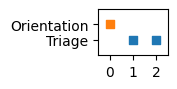

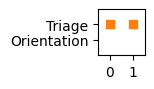

In [14]:

# Visualize the files with two scenes
mask_series = (triage_count_df.triage_count == 2)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list)

# Add the scene type for each run
highlighted_ngrams = ['Triage', 'Orientation']
sequences_set = set()
for (file_name), file_name_df in frvrs_logs_df[mask_series].groupby(['file_name']):
    sequence = []
    for (scene_index), scene_df in file_name_df.groupby(['scene_index']):
        scene_type = fu.get_scene_type(scene_df)
        if len(scene_type) != 1: raise
        else: scene_type = scene_type[0]
        sequence.append(scene_type)
    sequences_set.add(str(sequence))
for sequence in sorted([eval(s) for s in sequences_set]):
    nu.plot_sequence(sequence, highlighted_ngrams=highlighted_ngrams, suptitle=None, verbose=False)

In [11]:

# Display the size of the first and last triage of the files with two scenes
mask_series = (triage_count_df.triage_count == 2)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list) & (frvrs_logs_df.scene_type == 'Triage')
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted']
count_tuples_list = []
for (file_name), file_name_df in frvrs_logs_df[mask_series].groupby('file_name'):
    min_triage = file_name_df.scene_index.min()
    mask_series = (frvrs_logs_df.scene_index == min_triage) & (frvrs_logs_df.file_name == file_name)
    df = frvrs_logs_df[mask_series]
    min_count = df.shape[0]
    mask_series &= ~frvrs_logs_df.voice_capture_message.isnull()
    df = frvrs_logs_df[mask_series]
    display(df.sort_values('action_tick').tail(4).dropna(axis='columns', how='all').T)
    
    max_triage = file_name_df.scene_index.max()
    mask_series = (frvrs_logs_df.scene_index == max_triage) & (frvrs_logs_df.file_name == file_name)
    df = frvrs_logs_df[mask_series]
    max_count = df.shape[0]
    mask_series &= ~frvrs_logs_df.voice_capture_message.isnull()
    df = frvrs_logs_df[mask_series]
    display(df.sort_values('action_tick').head(4).dropna(axis='columns', how='all').T)
    
    # if df.shape[0]: display(df[columns_list].sample(min(4, df.shape[0])).T)
    count_tuple = (file_name, min_count, max_count)
    count_tuples_list.append(count_tuple)
    break
for count_tuple in count_tuples_list[:3]:
    print(*count_tuple)

,56803,56845,56846
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
action_tick,515577,528010,532214
event_time,2023-03-15 12:11:42,2023-03-15 12:11:54,2023-03-15 12:11:58
session_uuid,a7804ee3-6a1c-4462-957a-17976a540483,a7804ee3-6a1c-4462-957a-17976a540483,a7804ee3-6a1c-4462-957a-17976a540483
file_name,All CSV files renamed by date/03.15.23.1220.csv,All CSV files renamed by date/03.15.23.1220.csv,All CSV files renamed by date/03.15.23.1220.csv
logger_version,1.3,1.3,1.3
scene_index,1,1,1
voice_capture_message,subway station i mean there might be a victim ...,yeah no i had like one like crush injury and t...,OK
voice_capture_command_description,NA,NA,NA
voice_capture_sentiment_score,-0.2732,0.4767,0.296


,56848,56849,56850,56859
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
action_tick,538949,541172,547274,552631
event_time,2023-03-15 12:12:05,2023-03-15 12:12:07,2023-03-15 12:12:13,2023-03-15 12:12:19
session_uuid,a7804ee3-6a1c-4462-957a-17976a540483,a7804ee3-6a1c-4462-957a-17976a540483,a7804ee3-6a1c-4462-957a-17976a540483,a7804ee3-6a1c-4462-957a-17976a540483
file_name,All CSV files renamed by date/03.15.23.1220.csv,All CSV files renamed by date/03.15.23.1220.csv,All CSV files renamed by date/03.15.23.1220.csv,All CSV files renamed by date/03.15.23.1220.csv
logger_version,1.3,1.3,1.3,1.3
scene_index,2,2,2,2
voice_capture_message,it's just me,oh got 18,oh i did terrible but i was fast,oh ****
voice_capture_command_description,NA,NA,NA,NA
voice_capture_sentiment_score,0.0,0.0,-0.2617,0.0


All CSV files renamed by date/03.15.23.1220.csv 45 761


In [12]:

# Verify that the files with three triage scenes are mixed scenes
mask_series = (triage_count_df.triage_count == 3)
file_names_list = triage_count_df[mask_series].file_name.tolist()
mask_series = frvrs_logs_df.file_name.isin(file_names_list)
columns_list = ['session_uuid', 'file_name', 'logger_version', 'scene_index', 'scene_type', 'is_scene_aborted']
nu.get_minority_combinations(frvrs_logs_df[mask_series][columns_list], ['scene_type', 'is_scene_aborted'])

,session_uuid,file_name,logger_version,scene_index,scene_type,is_scene_aborted
680975,0b891add-e0c3-463d-948d-7f491f1d10ef,v.1.0/Clean 0b891add-e0c3-463d-948d-7f491f1d10...,1.0,1,Orientation,False
645928,0dc94285-ba14-40aa-9745-76504502a5cc,Disaster Day 2022/TW_1019.csv,1.3,2,Triage,False


In [31]:

tool_applied_sender = 'AppliedTourniquet'
columns_list = [cn for cn in frvrs_logs_df.columns if 'appl' in cn]
mask_series = False
for cn in columns_list: mask_series |= ~frvrs_logs_df[cn].isnull()
df = frvrs_logs_df[mask_series][columns_list]
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,781307,85175,205142,59532
tool_applied_type,NaN,NaN,Gauze_Pack,NaN
tool_applied_attachment_point,NaN,NaN,skinCollider_BodyLOD (UnityEngine.GameObject),NaN
tool_applied_sender,NaN,NaN,AppliedPackingGauze,NaN
tag_applied_patient_id,Lily_2 Root,Mike_1 Root,NaN,Lily_4 Root
tag_applied_type,red,yellow,NaN,red
tool_applied_patient_id,NaN,NaN,Lily_4 Root,NaN


In [39]:

columns_list = ['tool_applied_type', 'tool_applied_sender']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,tool_applied_type,tool_applied_sender
211,Gauze_Dressing,AppliedDressingGauze
170,Gauze_Pack,AppliedPackingGauze
237202,Naso,AppliedTrumpet
51,Needle,Needle_Decomp(Clone) (UnityEngine.GameObject)
111,Tourniquet,AppliedTourniquet
0,NaN,NaN


In [37]:

columns_list = [cn for cn in frvrs_logs_df.columns if 'required' in cn]
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,injury_record_required_procedure,injury_treated_required_procedure
260,airway,NaN
6,decompress,NaN
12,gauzePressure,NaN
251,none,NaN
10,tourniquet,NaN
8,woundpack,NaN
67102,NaN,airway
50,NaN,decompress
210,NaN,gauzePressure
112634,NaN,none


In [62]:

columns_list = ['action_tick', 'injury_id', 'injury_treated_injury_treated']
injury_records_df.sort_values(columns_list).dropna(axis='columns', how='all').T#[columns_list].drop_duplicates()

,35816,36061
action_type,INJURY_RECORD,INJURY_TREATED
action_tick,470109,661578
event_time,2023-03-14 12:39:32,2023-03-14 12:42:43
session_uuid,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655
file_name,All CSV files renamed by date/03.14.23.1247-40...,All CSV files renamed by date/03.14.23.1247-40...
logger_version,1.0,1.0
scene_index,1,1
injury_record_id,R Shin Amputation,NaN
injury_record_patient_id,Lily_2 Root,NaN
injury_record_required_procedure,tourniquet,NaN


In [6]:

def convert_uuid_to_rgb(uuid):
    """
    Converts a UUID to an RGB color.
    
    Args:
        uuid: A UUID string.
    
    Returns:
        A tuple of three integers representing the RGB color.
    """
    
    # Split the UUID into five parts
    uuid_parts = uuid.split('-')
    
    # Convert each part of the UUID to an integer
    uuid_ints = [int(part, 16) for part in uuid_parts]
    
    # Calculate the red, green, and blue components of the color
    red = (uuid_ints[-3] % 256) / 256
    green = (uuid_ints[-2] % 256) / 256
    blue = (uuid_ints[-1] % 256) / 256
    
    # Return the RGB color as a tuple of three integers
    return (red, green, blue)

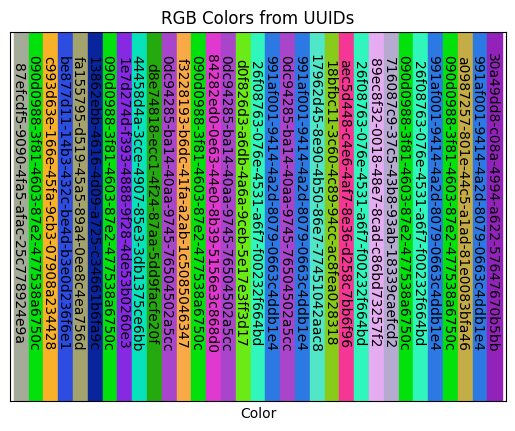

In [7]:

# Create a list of the RGB colors for each UUID
uuids_list = frvrs_logs_df.sample(33).session_uuid.tolist()
colors = [convert_uuid_to_rgb(uuid) for uuid in uuids_list]

# Create a figure and axes
fig, ax = plt.subplots()

# Create a rectangle for each color
for i in range(len(colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))

# Set the x and y limits
ax.set_xlim(-0.25, len(colors) + 0.25)
ax.set_ylim(0, 1)

# Set the x and y labels
ax.set_xlabel('Color')

# Turn off the axes
ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_yticks([])

# Set the title
ax.set_title('RGB Colors from UUIDs')

# Annotate each UUID
for i in range(len(uuids_list)):
    ax.annotate(
        uuids_list[i],
        xy=(i + 1.25, 0.5),
        xytext=(-10, 10),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        va='center',
        rotation=-90
    )

# Show the plot
plt.show()

In [23]:

def remove_consecutive_repeating_elements(scene_idx_list):
    """
    Removes the consecutive repeating elements without losing the original order.
    
    Args:
        scene_idx_list: A list of scene indices.
    
    Returns:
        A list of scene indices without the consecutive repeating elements.
    """
    
    unique_scene_idx_list = []
    previous_scene_idx = None
    for scene_idx in scene_idx_list:
        if scene_idx != previous_scene_idx: unique_scene_idx_list.append(scene_idx)
        previous_scene_idx = scene_idx
    
    return unique_scene_idx_list


scene_idx_list = [0, 0, 0, 1, 1, 2, 0, 3, 3, 3]
unique_scene_idx_list = remove_consecutive_repeating_elements(scene_idx_list)

print(unique_scene_idx_list)

[0, 1, 2, 0, 3]


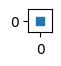

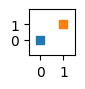

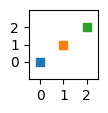

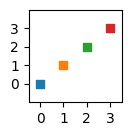

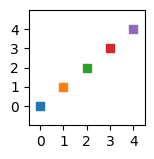

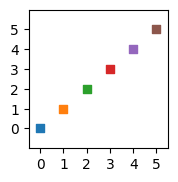

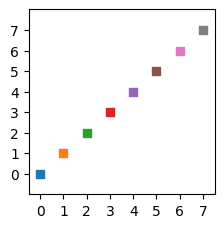

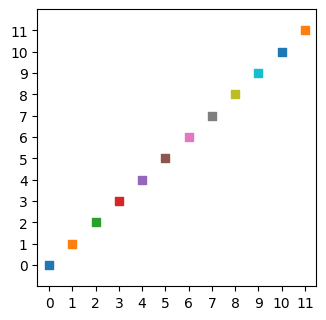

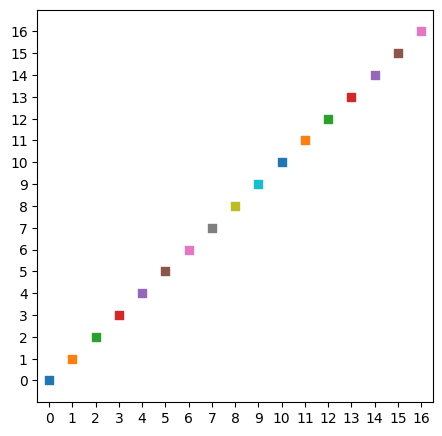

In [31]:

sequences_set = set()
for file_name, file_name_df in frvrs_logs_df.groupby('file_name'):
    scene_idx_list = file_name_df.sort_values('action_tick').scene_index.tolist()
    sequence = remove_consecutive_repeating_elements(scene_idx_list)
    assert sorted(sequence) == sequence, "Stop the presses!!"
    sequences_set.add(str(sequence))
for sequence in sorted([eval(s) for s in sequences_set]):
    nu.plot_sequence(sequence, highlighted_ngrams=[], suptitle=None, verbose=False)

In [3]:

def get_datetime_indexes(df):
    """
    Groups the event times by consecutive minutes.

    Args:
        df: A Pandas DataFrame containing the event times.

    Returns:
        A list of DatetimeIndexes, each representing a group of consecutive minutes.
    """

    by_minute = timedelta(minutes=1)
    
    # Create a list of time stamps
    time_stamps = sorted(df.event_time.unique())
    
    # Calculate the time difference between consecutive time stamps
    time_diffs = [b - a for a, b in zip(time_stamps[:-1], time_stamps[1:])]
    
    # Check if any of the time differences are larger than a minute
    if any(time_diff > by_minute for time_diff in time_diffs):
        
        # Create a list of groups
        groups = []
        current_group = []
        for time_stamp, time_diff in zip(time_stamps, time_diffs):
            current_group.append(time_stamp)
            if time_diff > by_minute:
                groups.append(current_group)
                current_group = []
        
        # Add the last group to the list of groups
        current_group.append(time_stamps[-1])
        groups.append(current_group)
            
    else: groups = [time_stamps]
    
    # Create a list of DatetimeIndexes
    datetime_indexes_list = []
    for stamps_list in groups:
        start_date = min(stamps_list)
        end_date = max(stamps_list)
        datetime_index = pd.date_range(start=start_date, end=end_date, freq=by_minute)
        datetime_indexes_list.append(datetime_index)

    return datetime_indexes_list

In [ ]:

    
    # Add scenes for missing scene indexes
    missing_mask_series = df.scene_index.isnull()
    missing_columns_list = ['action_type', 'action_tick', 'event_time', 'session_uuid', 'scene_index']
    if df[missing_mask_series].shape[0]:
        scene_idx_list = df[~missing_mask_series].scene_index.unique().tolist()
        if (len(scene_idx_list) == 1): df.loc[missing_mask_series, 'scene_index'] = scene_idx_list[0]
        elif (len(scene_idx_list) == 0): df.loc[missing_mask_series, 'scene_index'] = 0
    if df[missing_mask_series].shape[0]:
        columns_list = ['session_uuid', 'action_tick', 'event_time']
        srs = df[columns_list].groupby(['session_uuid']).apply(get_datetime_indexes)
        for session_uuid in srs.index:
            datetime_indexes_list = srs[session_uuid]
            for i, datetime_index in enumerate(datetime_indexes_list):
                mask_series = (df.session_uuid == session_uuid) & df.event_time.isin(datetime_index)
                df.loc[mask_series, 'scene_index'] = df[mask_series].scene_index.mode()
                display(df[mask_series][missing_columns_list])

In [18]:

frvrs_logs_df = frvrs_logs_df.rename(columns={'scene_index': 'scene_index'})
nu.store_objects(frvrs_logs_df=frvrs_logs_df)
nu.save_data_frames(frvrs_logs_df=frvrs_logs_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\frvrs_logs_df.pkl
Saving to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\csv\frvrs_logs_df.csv


In [ ]:

if ('session_type' in frvrs_logs_df.columns): frvrs_logs_df = frvrs_logs_df.drop(columns=['session_type'])

In [ ]:

        # display(fu.get_statistics(['patient_count'], df).applymap(lambda x: round(x, 1), na_action='ignore').rename(
        #     columns={'patient_count': f'{column_value.lower()}_patient_count'}
        # ).T)

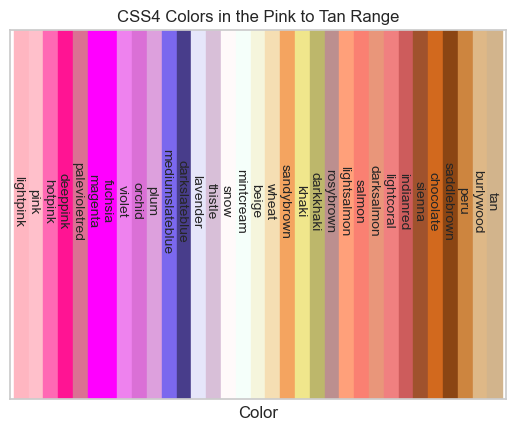

In [133]:

import matplotlib.colors as mcolors

# Create a list of the CSS4 colors in the pink to tan range
colors = [
    'lightpink', 'pink', 'hotpink', 'deeppink', 'palevioletred', 'magenta',
    'fuchsia', 'violet', 'orchid', 'plum', 'mediumslateblue', 'darkslateblue',
    'lavender', 'thistle', 'snow', 'mintcream', 'beige', 'wheat', 'sandybrown',
    'khaki', 'darkkhaki', 'rosybrown', 'lightsalmon', 'salmon', 'darksalmon',
    'lightcoral', 'indianred', 'sienna', 'chocolate', 'saddlebrown', 'peru',
    'burlywood', 'tan'
]

# Create a figure and axes
fig, ax = plt.subplots()

# Create a rectangle for each color
for i in range(len(colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))

# Set the x and y limits
ax.set_xlim(-0.25, len(colors) + 0.25)
ax.set_ylim(0, 1)

# Set the x and y labels
ax.set_xlabel('Color')

# Turn off the axes
ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_yticks([])

# Set the title
ax.set_title('CSS4 Colors in the Pink to Tan Range')

# Annotate each color
for i in range(len(colors)):
    ax.annotate(
        colors[i],
        xy=(i + 1.25, 0.5),
        xytext=(-10, 10),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        va='center',
        rotation=-90
    )

# Show the plot
plt.show()

In [8]:

# Investigate the presence of colors
colors_list = [
    'red',
    'yellow',
    'black',
    'gray',
    'green'
]
for color in colors_list:
    srs = frvrs_logs_df.applymap(lambda x: color in str(x).lower(), na_action='ignore').sum()
    columns_list = srs[srs != 0].index.tolist()
    if columns_list:
        print(color, columns_list)

red ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
yellow ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
black ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
gray ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
green ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']


In [ ]:
 if any(map(lambda x: (x in fn), ['class', 'featur']))

In [6]:



loop1 = frvrs_logs_df.groupby(fu.patient_groupby_columns).size().shape[0]
input_features = [
    'patient_record_salt', 'patient_record_sort', 'patient_record_pulse', 'patient_record_breath', 'patient_record_hearing', 'patient_record_mood',
    'patient_record_pose', 'injury_record_id', 'injury_record_required_procedure', 'injury_record_severity', 'injury_record_body_region',
    'injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'pulse_taken_pulse_name', 'patient_engaged_salt',
    'patient_engaged_sort', 'patient_engaged_pulse', 'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose',
    'injury_treated_id', 'injury_treated_required_procedure', 'injury_treated_severity', 'injury_treated_body_region', 'injury_treated_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'tool_applied_type', 'tool_applied_attachment_point', 'tool_applied_tool_location',
    'tool_applied_data', 'tool_applied_sender'
    ]
loop2 = len(input_features)
loop3 = frvrs_logs_df.action_type.unique().shape[0]
loop_total = loop1 * loop2 * loop3
print(f"I'm looping through each patient, run, and session (x{loop1:,}) and the input features columns (x{loop2}) prepended with each of the action types (x{loop3}) for a total of {loop_total:,} loops.")

I'm looping through each patient, run, and session (x9,874) and the input features columns (x32) prepended with each of the action types (x26) for a total of 8,215,168 loops.


,notice_to_control_time,responder_count
0,11219.0,98.0
1,258123.4,169.0
2,505027.8,140.0
3,751932.2,120.0
4,998836.6,56.0
5,1245741.0,22.0
6,1492645.4,7.0
7,1739549.8,0.0
8,1986454.2,5.0
9,2233358.6,1.0


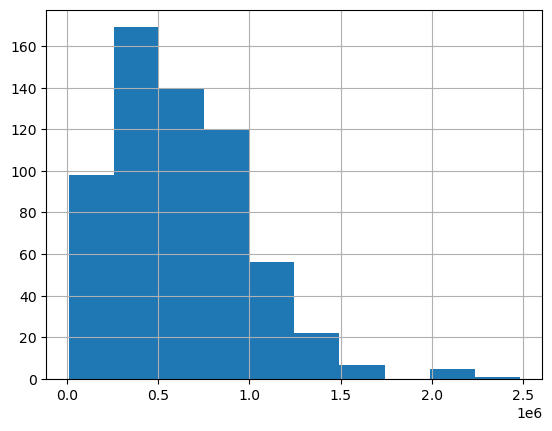

In [31]:

df = notice_to_control_time_df.groupby(groupby_columns).sum()
hist_obj = df.notice_to_control_time.hist()
[f'hist_obj.{fn}' for fn in dir(hist_obj) if any(map(lambda x: x in fn, ['height', 'bin', 'patch']))]

# Extract heights and x-coordinates of the bars
rows_list = [{'notice_to_control_time': rect.get_x(), 'responder_count': rect.get_height()} for rect in hist_obj.patches]
pd.DataFrame(rows_list)

In [30]:

[f'hist_obj.{fn}' for fn in dir(hist_obj) if fn.startswith('get_')]

['hist_obj.get_adjustable', 'hist_obj.get_agg_filter', 'hist_obj.get_alpha', 'hist_obj.get_anchor', 'hist_obj.get_animated', 'hist_obj.get_aspect', 'hist_obj.get_autoscale_on', 'hist_obj.get_autoscalex_on', 'hist_obj.get_autoscaley_on', 'hist_obj.get_axes_locator', 'hist_obj.get_axisbelow', 'hist_obj.get_box_aspect', 'hist_obj.get_children', 'hist_obj.get_clip_box', 'hist_obj.get_clip_on', 'hist_obj.get_clip_path', 'hist_obj.get_cursor_data', 'hist_obj.get_data_ratio', 'hist_obj.get_default_bbox_extra_artists', 'hist_obj.get_facecolor', 'hist_obj.get_fc', 'hist_obj.get_figure', 'hist_obj.get_frame_on', 'hist_obj.get_gid', 'hist_obj.get_gridspec', 'hist_obj.get_images', 'hist_obj.get_in_layout', 'hist_obj.get_label', 'hist_obj.get_legend', 'hist_obj.get_legend_handles_labels', 'hist_obj.get_lines', 'hist_obj.get_mouseover', 'hist_obj.get_navigate', 'hist_obj.get_navigate_mode', 'hist_obj.get_path_effects', 'hist_obj.get_picker', 'hist_obj.get_position', 'hist_obj.get_rasterization_zorde

In [29]:

  #   +------------------+
  #   |                  |
  # height               |
  #   |                  |
  #  (xy)---- width -----+
hist_obj.patch?

Type:           Rectangle
String form:    Rectangle(xy=(0, 0), width=1, height=1, angle=0)
File:           c:\users\davebabbitt\documents\github\notebooks\nb_env\lib\site-packages\matplotlib\patches.py
Docstring:     
A rectangle defined via an anchor point *xy* and its *width* and *height*.

The rectangle extends from ``xy[0]`` to ``xy[0] + width`` in x-direction
and from ``xy[1]`` to ``xy[1] + height`` in y-direction. ::

  :                +------------------+
  :                |                  |
  :              height               |
  :                |                  |
  :               (xy)---- width -----+

One may picture *xy* as the bottom left corner, but which corner *xy* is
actually depends on the direction of the axis and the sign of *width*
and *height*; e.g. *xy* would be the bottom right corner if the x-axis
was inverted or if *width* was negative.
Init docstring:
Parameters
----------
xy : (float, float)
    The anchor point.
width : float
    Rectangle width.
h

In [28]:

for patch in hist_obj.patches:
    display(dir(patch))
    break

['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiased', '_aspect_ratio_correction', '_axes', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_convert_units', '_convert_xy_units', '_dash_pattern', '_default_contains', '_draw_paths_with_artist_properties', '_edge_default', '_edgecolor', '_facecolor', '_fill', '_fully_clipped_to_axes', '_gid', '_hatch', '_hatch_color', '_height', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyle', '_linewidth', '_mouseover', '_original_edgecolor', '_original_facecolor', '_path_effects', '_picker', '_process_radius', '_rast

In [24]:

from collections import Counter

# Count the lengths of sequences in consecutive_time_groups_dict
sequence_lengths = [len(actions_list) for actions_list in time_groups_dict.values()]

# Find the most common sequence length and its count
most_common_length, count = Counter(sequence_lengths).most_common(1)[0]

print(f'The most popular sequence length among the values of the time_groups_dict is {most_common_length}, occurring {count} times.')

The most popular sequence length among the values of the time_groups_dict is 1, occurring 58 times.


In [25]:

import pandas as pd
from collections import Counter

# Count the lengths of sequences in consecutive_time_groups_dict
sequence_lengths = [len(actions_list) for actions_list in consecutive_time_groups_dict.values()]

# Convert sequence_lengths list into a pandas Series
sequence_lengths_series = pd.Series(sequence_lengths)

# Get the value counts of unique sequence lengths
value_counts = sequence_lengths_series.value_counts()

print('Value counts of unique sequence lengths of the consecutive_time_groups_dict:')
print(value_counts)

Value counts of unique sequence lengths:
3     187
5     125
1      82
4      74
7      64
6      51
2      45
9      29
10     21
8      15
11     10
12      8
13      7
14      4
16      2
15      1
Name: count, dtype: int64


In [10]:

import random

values_list = random.sample(notice_to_control_time_df.notice_to_control_time.tolist(), 10)
print(f'''
notice_to_control_time_df = pd.DataFrame({{'notice_to_control_time': {values_list}}})''')


notice_to_control_time_df = pd.DataFrame({'notice_to_control_time': [565204, 66933, 180636, 170767, 266339, 255253, 244320, 82204, 93897, 363529]})


In [ ]:

.sort_values(list(columns_dict.values()), ascending=[False]*len(columns_dict.values()))

In [ ]:

            # print(previous_time, action_tick, session_uuid, scene_index, patient_id, previous_time > action_tick)
            if (previous_time > action_tick):
                display(df1[mask_series].sort_values('action_tick').head(4).dropna(axis='columns', how='all').T)
                display(df2.sample(min(4, df2.shape[0])).dropna(axis='columns', how='all').T)
                raise

In [ ]:

    print(f"""
    groupby_columns = {df.columns.tolist()}
    gb = df.groupby(groupby_columns)
    rows_list = []
    for ({', '.join(df.columns)}), df1 in gb:""")

In [ ]:

    
    # Investigate the presence of trunk, neck, junctional or extremity info
    for search_str in ['trunk', 'neck', 'junctional', 'extremity']:
        srs = df2.applymap(lambda x: search_str in str(x).lower(), na_action='ignore').sum()
        columns_list = srs[srs != 0].index.tolist()
        if columns_list:
            print(search_str, columns_list)

In [ ]:

required_columns_list = [cn for cn in frvrs_logs_df.columns if cn.endswith('_required_procedure')]
mask_series = False
for cn in required_columns_list: mask_series |= (frvrs_logs_df[cn].isin(['tourniquet', 'woundpack']))

In [ ]:

fn = lambda x: ('gaze' in str(x).lower())
srs = frvrs_logs_df.applymap(fn, na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
print(columns_list)
for cn in columns_list:
    print(cn)
    mask_series = frvrs_logs_df[cn].map(fn)
    df = frvrs_logs_df[mask_series]
    
    # Display a sample of the data frame, dropping columns with all NaN values and transposing it
    display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

In [ ]:


# tick_locations = ax.get_xticks()
# print(tick_locations)

# tick_labels = ax.get_xticklabels()
# print(tick_labels)

In [11]:

print('\n'.join(sorted('''**/.ipynb_checkpoints/
*.ipynb_checkpoints
*/.ipynb_checkpoints
.ipynb_checkpoints
.ipynb_checkpoints*
.ipynb_checkpoints/
.ipynb_checkpoints/*
/.ipynb_checkpoints'''.split('\n'), key=lambda x: x[::-1])))

.ipynb_checkpoints/*
.ipynb_checkpoints*
.ipynb_checkpoints/
**/.ipynb_checkpoints/
.ipynb_checkpoints
*.ipynb_checkpoints
/.ipynb_checkpoints
*/.ipynb_checkpoints
